<h1> Mini AGN Search </h1>

Hi! in this mini project, I search for AGN using LOFAR and VLA data in 1deg by 1deg area of the coma constellation. I compute the spectral indices for the 22 relevant sources and then plot the data in various ways. I also compare the data to a photo I took.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import pandas as pd
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.io import fits


#start with the LOFAR data, which is very roughly around 150 MHz
lofar_data_table = Table.read('combined-release-v1.1-LM_opt_mass.fits')

# Convert the table to a pandas DataFrame for easier manipulation
df_lofar = lofar_data_table.to_pandas()

In [3]:
# Use flag_qual == 1 to get only the "nice" sources
df_lofar = df_lofar[df_lofar['flag_qual'] == 1]
# overwriting should be fine here

Because I want to compare the two frequency domains, I first want to find an area where we have sufficient data in both sets <p />
The following 3 plots are just for me to get an understanding of what I'm working with

DEC min: 16.086076025414048, DEC max: 69.64415878929005


Text(0, 0.5, 'DEC (deg)')

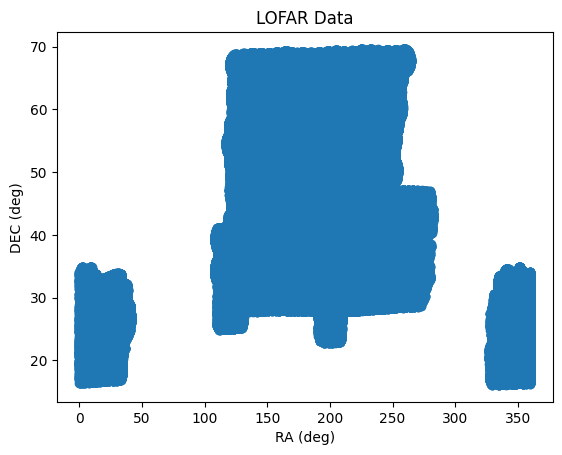

In [44]:
# get an idea what I'm looking at
#print(df_lofar.head)
dec_max = df_lofar['DEC'].max()
dec_min = df_lofar['DEC'].min()
print(f"DEC min: {dec_min}, DEC max: {dec_max}")
plt.scatter(df_lofar['RA'], df_lofar['DEC'])
plt.title('LOFAR Data')
plt.xlabel('RA (deg)')
plt.ylabel('DEC (deg)')

In [5]:
#load the FIRST dataset, which is at around 1.4 GHz

first_data_table = Table.read('first_14dec17.fits')

df_first = first_data_table.to_pandas()

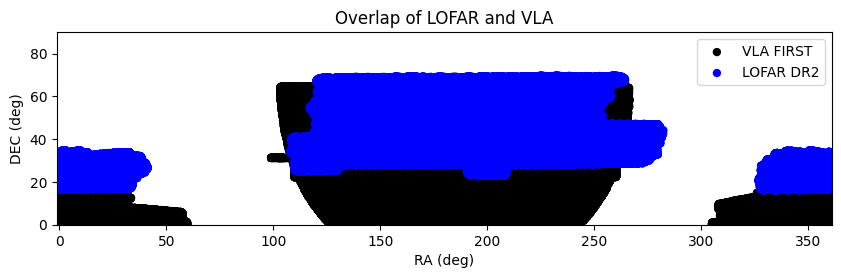

In [66]:
# same thing for the FIRST data
#print(df_first.head)
fig = plt.figure(figsize=(10, 2.5))
subplot = fig.add_subplot(1, 1, 1)
subplot.scatter(df_first['RA'], df_first['DEC'], color = 'black', alpha=1, edgecolors='none', label='VLA FIRST')
subplot.scatter(df_lofar['RA'], df_lofar['DEC'], color='blue', alpha=1, edgecolors='none', label='LOFAR DR2')
plt.title('Overlap of LOFAR and VLA')
plt.xlabel('RA (deg)')
plt.ylabel('DEC (deg)')
plt.axis('equal')
plt.xlim(0, 360)
plt.ylim(0, 90)
plt.legend(loc='upper right')
plt.show()

I can pick some region that is overlapping now. Originally, I wanted to look at 3C 273 and M87, but that region isn't covered by this LOFAR set, so I'll look for another interesting region <p />
Using the NASA/IPAC extragalactic database, we can look for an interesting region that contains QSO (quasars) within our constraints (search by parameters, RA $\in$ [10h, 13h] ; DEC $\in$ [30D, 60D]) (cyan)<p />
We can then plot the result from the search in the same plot after converting it into a CSV file

(9, 17)
(24391, 17)
(2318696, 123)
(946432, 25)


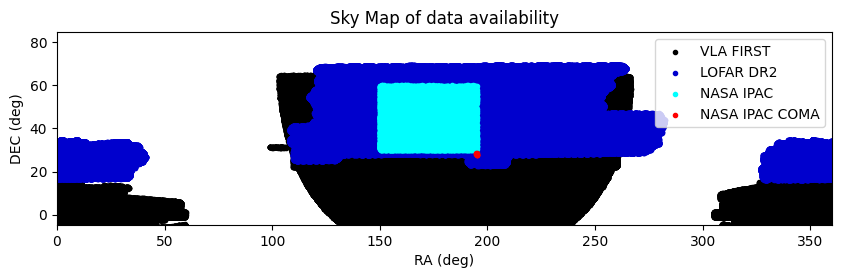

   No.                Object Name         RA       DEC Type  Velocity  \
0    1            [HB89] 1256+284  194.83513  28.22662  QSO    644293   
1    2  WISEA J125930.95+282705.5  194.87899  28.45154  QSO    328555   
2    3  WISEA J125933.53+281739.9  194.88971  28.29444    G     41401   
3    4            [HB89] 1257+287  194.96310  28.45821  QSO    896380   
4    5  WISEA J130002.41+274015.4  195.00987  27.67078    *    749178   

   Redshift Redshift Flag Magnitude and Filter  Separation  References  Notes  \
0   2.14913          SLS                 19.2          0.0          21      0   
1   1.09594          SLS                 19.3g         0.0          40      0   
2   0.13810          SUN                 19.36         0.0          17      0   
3   2.99000          SUN                 19.6          0.0           8      0   
4   2.49899          SLS                 21.7g         0.0           7      0   

   Photometry Points  Positions  Redshift Points  Diameter Points  \
0    

In [67]:
NASA_IPAC_search = pd.read_csv('NASA_IPAC_search.txt', sep = '|', skiprows=21 )
NASA_IPAC_COMA_search = pd.read_csv('NASA_IPAC_coma_coord.txt', sep = '|', skiprows=21 )
print(NASA_IPAC_COMA_search.shape)
print(NASA_IPAC_search.shape)
print(df_lofar.shape)
print(df_first.shape)
fig = plt.figure(figsize=(10, 2.5))
subplot = fig.add_subplot(1, 1, 1)
subplot.scatter(df_first['RA'], df_first['DEC'], color = 'black', alpha=1, marker='.', label='VLA FIRST')
subplot.scatter(df_lofar['RA'], df_lofar['DEC'], color='mediumblue', alpha=1, marker='.', label='LOFAR DR2')
subplot.scatter(NASA_IPAC_search['RA'], NASA_IPAC_search['DEC'], color='cyan', alpha=1, marker='.', label='NASA IPAC')
subplot.scatter(NASA_IPAC_COMA_search['RA'], NASA_IPAC_COMA_search['DEC'], color='red', alpha=1, marker='.', label='NASA IPAC COMA')
plt.title('Sky Map of data availability')
plt.xlabel('RA (deg)')
plt.ylabel('DEC (deg)')
plt.axis('equal')
plt.xlim(0, 360)
plt.ylim(0, 80)
plt.legend(loc='upper right')
plt.show()
print(NASA_IPAC_COMA_search.head())


Since this is much more than I expected, I'll aim for the Coma cluster instead. First I want to figure out the area I'm aiming for

In [61]:
import astropy.units as u

coma_coords = SkyCoord(ra=194.95*u.deg, dec=+27.98*u.deg) # coordinates from NASA/IPAC
coma_diameter_mly = 20
coma_distance_mly = 321
#theta = np.arctan(0.5*coma_diameter_mly / coma_distance_mly) / np.pi * 180
#print(f"theta: {theta} degrees")
# lets make this more conservative and just use 0.5 degrees and see what radius we're looking at 321 Mly away
theta = 0.5
radius = np.tan(theta * np.pi / 180) * coma_distance_mly
print(f"radius: {radius} Mly")
print(f"coma coordinates: {coma_coords}")

radius: 2.8013245608335713 Mly
coma coordinates: <SkyCoord (ICRS): (ra, dec) in deg
    (194.95, 27.98)>


In [9]:
lofar_coma = df_lofar[ (df_lofar['RA'] > coma_coords.ra.value - theta) & (df_lofar['RA'] < coma_coords.ra.value + theta) & (df_lofar['DEC'] > coma_coords.dec.value - theta) & (df_lofar['DEC'] < coma_coords.dec.value + theta) ]
print(f"LOFAR coma shape: {lofar_coma.shape}")
first_coma = df_first[ (df_first['RA'] > coma_coords.ra.value - theta) & (df_first['RA'] < coma_coords.ra.value + theta) & (df_first['DEC'] > coma_coords.dec.value - theta) & (df_first['DEC'] < coma_coords.dec.value + theta) ]
print(f"FIRST coma shape: {first_coma.shape}")
print(np.unique(lofar_coma['type']))
print(np.unique(first_coma['SDSS_CLASS']))
print((lofar_coma['RA']))

LOFAR coma shape: (431, 123)
FIRST coma shape: (109, 25)
[b'COMP' b'DEV' b'EXP' b'PSF' b'REX']
[b'-' b'g' b's']
2281945    194.451195
2282151    194.459312
2282234    194.462029
2282271    194.463293
2282281    194.463530
              ...    
2310199    195.431778
2310294    195.434687
2310306    195.435082
2310465    195.440030
2310669    195.447438
Name: RA, Length: 431, dtype: float64


At this point, I would like to futher filter the data by excluding certain types or classes from the datasets. However, my current knowledge isn't sufficient to accurately filter out AGNs based on the given parameters. That's why I'll go straight to matching coordinates.

In [10]:
import scipy

RA_LOFAR_COMA = np.array(lofar_coma['RA'] *u.deg)
DEC_LOFAR_COMA = np.array(lofar_coma['DEC'] *u.deg)
RA_FIRST_COMA = np.array(first_coma['RA'] *u.deg)
DEC_FIRST_COMA = np.array(first_coma['DEC'] *u.deg)

coords_lofar_coma = SkyCoord(ra=RA_LOFAR_COMA, dec=DEC_LOFAR_COMA, unit=(u.deg, u.deg))
coords_first_coma = SkyCoord(ra=RA_FIRST_COMA, dec=DEC_FIRST_COMA, unit=(u.deg, u.deg))

#matching the coords

index, d2d, any = coords_lofar_coma.match_to_catalog_sky(coords_first_coma)

#tolearance 
tol = 1
matched = d2d < tol * u.arcsec

# Get intersected subset
lofar_matched = lofar_coma.iloc[matched]
first_matched   = first_coma.iloc[index[matched]]
print(f"LOFAR matched shape: {lofar_matched.shape}")
print(f"FIRST matched shape: {first_matched.shape}")

LOFAR matched shape: (22, 123)
FIRST matched shape: (22, 25)


In my opinion, this already looks promising! <p />

Quick little status update: <p />
We are looking at a 1deg x 1deg area in the direction of the coma cluster. LOFAR data has also been quality-filtered. We have then matched positions of the objects in the two catalogues, so we now have 22 pairs of objects (1 in each dataset) that are within 1 arcsecond of each other. Theta and tol are arbitrary control parameters. <p />

We can now start analyzing the 22 sources further, let's start by looking at distances 

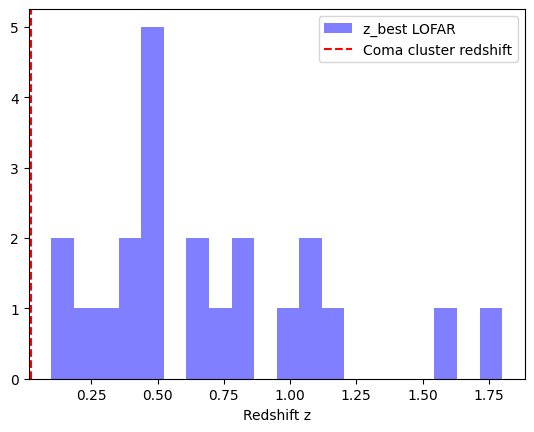

In [11]:
from astropy.cosmology import FlatLambdaCDM

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
luminosity_distance = cosmo.luminosity_distance(lofar_matched['z_best'])

plt.hist(lofar_matched['z_best'], bins=20, color='blue', alpha=0.5, label='z_best LOFAR')
plt.axvline(x=0.023, color='red', linestyle='--', label='Coma cluster redshift')
plt.xlabel('Redshift z')
plt.legend()

# Since the redshifts are orders of magnitude larger than the redshift of the coma cluster, we are not observing AGN that are part of the cluster, but behind it.
# This is consistent with the fact that there are no known AGN in the coma cluster (I think).

Unfortunately, the VLA dataset does not feature redshift values. But it is already pretty clear that these AGN are not part of the Coma Cluster

<h2>Final Result</h2>	

Now for the final result of this mini project: The Spectral indeces for the 22 objects. This is assuming that we are dealing with non-thermal radiation (i.e. synchrotron radiation from radio galaxies), which means we assume a power law $S_{\nu}=\nu^{p}$


Text(0.5, 1.0, 'Flux power law plot')

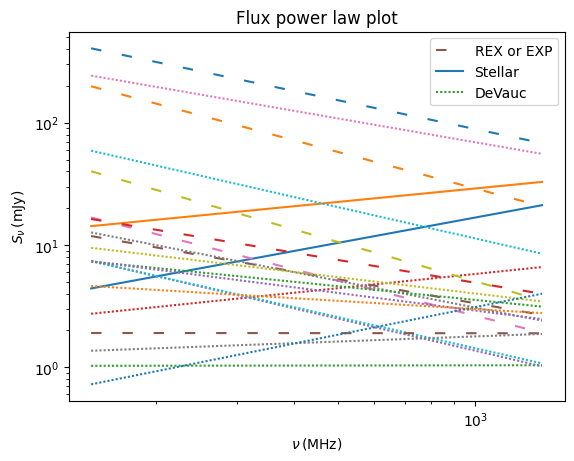

In [220]:
from scipy.stats import linregress

nu_lofar = 144 * u.MHz
nu_first = 1.4 * u.GHz

S_VLA = first_matched['FINT']
S_LOFAR = lofar_matched['Total_flux']
#Reindex, otherwise division doenst work
#S_VLA_reindex = S_VLA.reindex(S_LOFAR.index)
S_VLA_noindex = S_VLA.reset_index(drop=True)
S_LOFAR_noindex = S_LOFAR.reset_index(drop=True)


# plot data

nu_array = np.array([144, 1400])
spectral_index_regression = np.array([])
spectra_index_regression_error = np.array([])

# make linestyle -- for probable stars (pstar > 0.5)
# update: The idea is nice but pstar is below 3% for all sources
#print(lofar_matched['type'])

type_lofar_matched = lofar_matched['type']


a=np.array([])
for i in range(22):
    line = (0, (5, 10)) if type_lofar_matched.iloc[i] in [b'REX',b'EXP'] else '-' if type_lofar_matched.iloc[i] in [b'PSF']  else (0, (1, 1))
    b = plt.loglog(nu_array, np.array([S_LOFAR_noindex[i], S_VLA_noindex[i]]), linestyle=line)
    a = np.append(a,b)
    alpha, intercept, r_value, p_value, std_err = linregress(np.log10(np.array([144, 1400])), np.log10(np.array([S_LOFAR_noindex[i], S_VLA_noindex[i]])))

    spectral_index_regression = np.append(spectral_index_regression, alpha)

handles = [a[5], a[0], a[2]]
labels = ['REX or EXP', 'Stellar', 'DeVauc']

plt.xlabel(r'$\nu\,(\mathrm{MHz})$')
plt.ylabel(r'$S_{\nu}\,(\mathrm{mJy})$')
plt.xscale('log')
#plt.xticks([100, 1000] , [r'$10^2$', r'$10^3$'])
plt.yscale('log')
#plt.legend(handles=handles, labels=labels, loc='upper right', fontsize=12)
#plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(handles=handles, labels=labels, fancybox=True, loc='upper right', fontsize=10)
plt.title('Flux power law plot')


we found 11 steep spectrum sources
this is 2 more sources than we found in the NASA/IPAC AGN search, where we found 9 sources


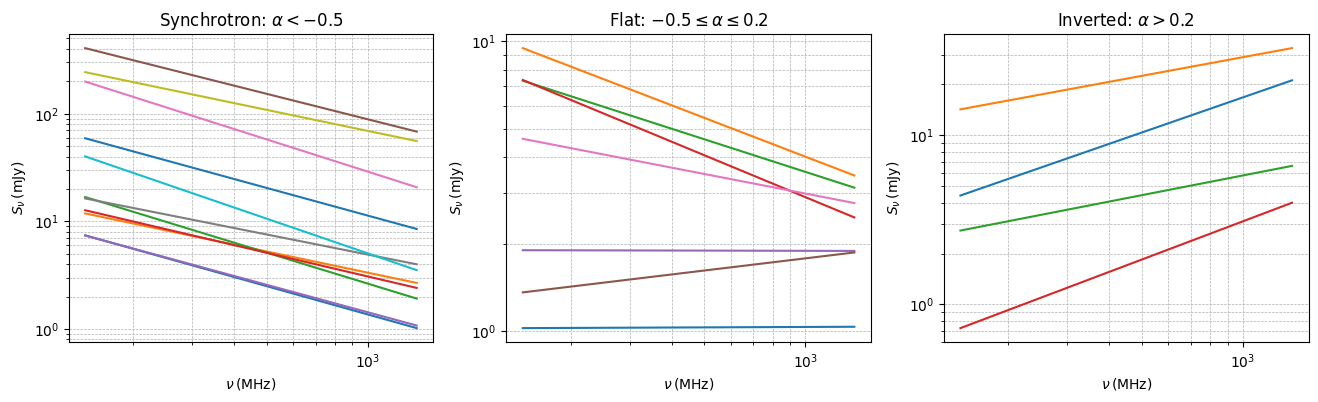

In [188]:
Spectral_index = np.log10(S_LOFAR_noindex / S_VLA_noindex) / np.log10(nu_lofar / nu_first)

#print(np.round(spectral_index_regression, 4) == np.round(Spectral_index, 4))

fig = plt.figure(figsize=(16, 4))
subplot0 = fig.add_subplot(1, 3, 1)
subplot1 = fig.add_subplot(1, 3, 2)
subplot2 = fig.add_subplot(1, 3, 3)
subplots = [subplot0, subplot1, subplot2]

steep_spectrum = Spectral_index < -0.5
flat_spectrum = (Spectral_index >= -0.5) & (Spectral_index <= 0.2)
inverted_spectrum = Spectral_index > 0.2
spectra = [steep_spectrum, flat_spectrum, inverted_spectrum]


for i in range(3):
    subplots[i].loglog(nu_array, np.array([S_LOFAR_noindex[spectra[i]], S_VLA_noindex[spectra[i]]]))
    subplots[i].set_xlabel(r'$\nu\,(\mathrm{MHz})$')
    subplots[i].set_ylabel(r'$S_{\nu}\,(\mathrm{mJy})$')
    subplots[i].grid(True, which='both', linestyle='--', linewidth=0.5)
    subplots[i].set_xscale('log')
    subplots[i].set_yscale('log')

subplot0.set_title(r'Synchrotron: $\alpha < -0.5$')
subplot1.set_title(r'Flat: $-0.5 \leq \alpha \leq 0.2$')
subplot2.set_title(r'Inverted: $\alpha > 0.2$')

# Flat spectrum sources could also be AGN, especially blazars.
# Inverted sprectrum sources are likely to be star forming galaxies, as they are not expected to be AGN.
print(f'we found {np.sum(steep_spectrum)} steep spectrum sources')
print(f'this is {np.sum(steep_spectrum)-NASA_IPAC_COMA_search.shape[0]} more sources than we found in the NASA/IPAC AGN search, where we found {NASA_IPAC_COMA_search.shape[0]} sources')

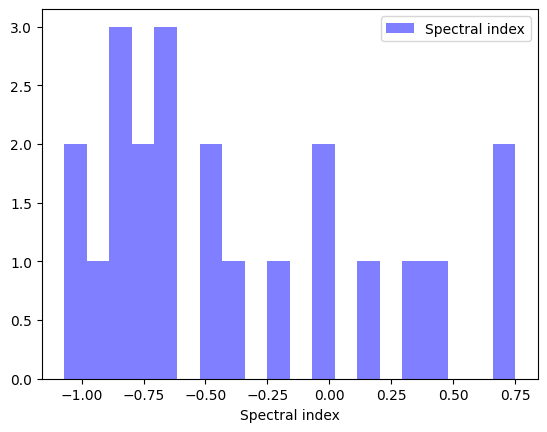

In [14]:
Spectral_index = np.log10(S_LOFAR_noindex / S_VLA_noindex) / np.log10(nu_lofar / nu_first)

plt.hist(Spectral_index, bins=20, color='blue', alpha=0.5, label='Spectral index')
plt.xlabel('Spectral index')

plt.legend()

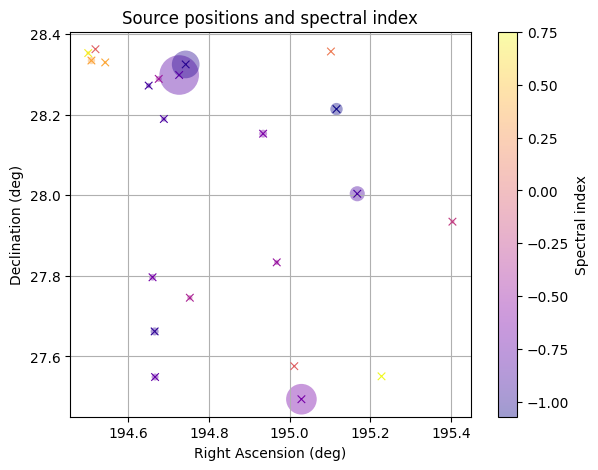

In [22]:
plt.figure (figsize=(7, 5))
scatter = plt.scatter(lofar_matched['RA'], lofar_matched['DEC'], c=Spectral_index, cmap='plasma', marker='x', s=30, linewidths=0.8, zorder=10)
aura = plt.scatter(lofar_matched['RA'], lofar_matched['DEC'], c=Spectral_index, cmap='plasma', s=2*(lofar_matched['Total_flux']), alpha=0.4, edgecolor='none',  linewidth=0.5)


cbar = plt.colorbar(aura)
cbar.set_label('Spectral index')

plt.xlabel('Right Ascension (deg)')
plt.ylabel('Declination (deg)')
plt.title('Source positions and spectral index')
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')

plt.show()

Let's also see how well the positions line up after the coordinate matching

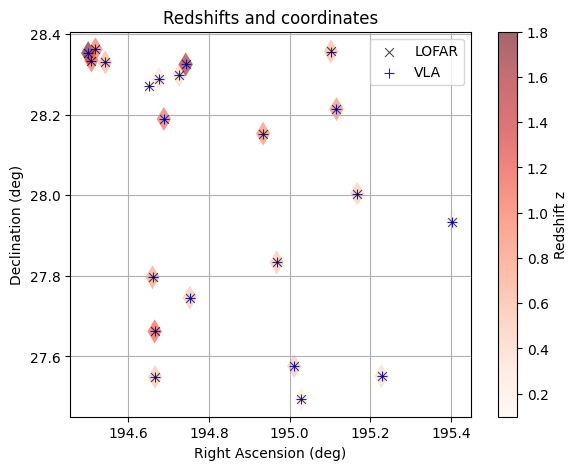

In [223]:


plt.figure (figsize=(7, 5))
lofar_scatter = plt.scatter(lofar_matched['RA'], lofar_matched['DEC'], c='black', marker='x', s=40, linewidths=0.8, alpha=0.7, label='LOFAR', zorder=10)
first_scatter = plt.scatter(first_matched['RA'], first_matched['DEC'], c='blue', marker='+', s=50, linewidths=0.8, alpha=0.9, label='VLA', zorder=5)

redshift_aura = plt.scatter(lofar_matched['RA'], lofar_matched['DEC'], c=lofar_matched['z_best'], cmap='Reds', marker='d', s=150, alpha=0.6, edgecolor='none',  linewidth=0.5)

cbar = plt.colorbar(redshift_aura)
cbar.set_label('Redshift z')



plt.xlabel('Right Ascension (deg)')
plt.ylabel('Declination (deg)')
plt.title('Redshifts and coordinates')
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(loc='upper right')

plt.show()


let's see if the spectral index is related to distance (it's not, but let's verify that it isn't!)

Text(0.5, 1.0, 'Spectral index vs redshift')

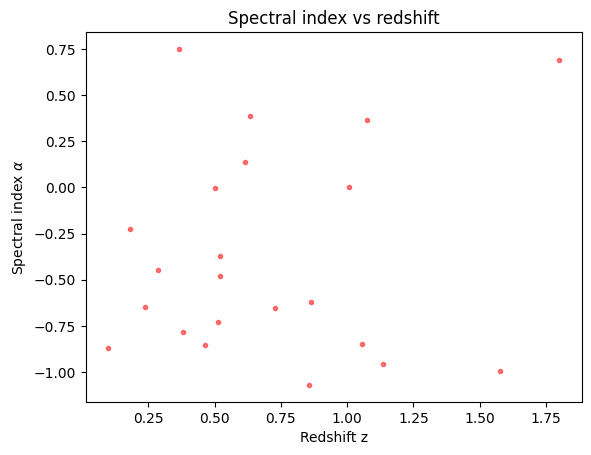

In [42]:
redshift = lofar_matched['z_best'].reset_index(drop=True)

plt.scatter(redshift, Spectral_index, color='red', alpha=0.5, marker = '.')
plt.xlabel('Redshift z')
plt.ylabel(r'Spectral index $\alpha$')
plt.title('Spectral index vs redshift')

<h2>Additional analysis using NASA/IPAC database</h2>	

We can also repeat coordinate matching with the NASA/IPAC AGN seach data and also see if redshifts line up (update: Doesn't work because they don't line up) <p />

I'm not entirely sure whether this is physically accurate, but I would like to try calculating the absolute magnitudes using total Flux and the redshift as a measure of distance. <p />

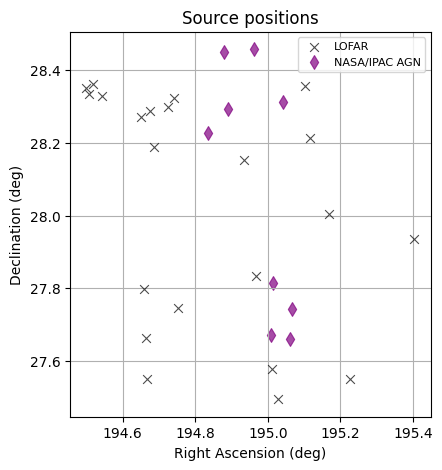

In [ ]:
plt.figure (figsize=(7, 5))
lofar_scatter = plt.scatter(lofar_matched['RA'], lofar_matched['DEC'], c='black', marker='x', s=40, linewidths=0.8, alpha=0.7, label='LOFAR', zorder=10)
NASA_scatter = plt.scatter(NASA_IPAC_COMA_search['RA'], NASA_IPAC_COMA_search['DEC'], c='purple', marker='d', s=50, linewidths=0.8, alpha=0.7, label='NASA/IPAC AGN')

plt.xlabel('Right Ascension (deg)')
plt.ylabel('Declination (deg)')
plt.title('Source positions')
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(loc='upper right', fontsize=8)

plt.show()

Unfortunately, the NASA/IPAC AGN search found sources that are entirely different to the ones I found in the LOFAR and VLA sets. Understanding this might require some deeper knowledge about the databases and general astrophysics than I currently have.

Let's compare out data to an image I took with my phone

<SkyCoord (ICRS): (ra, dec) in deg
    (194.95, 27.98)>
[[1727.26936031 2758.45480785]
 [1680.56736512 2757.50768569]
 [1681.41681503 2703.68979089]
 [1727.50246964 2704.58349509]]


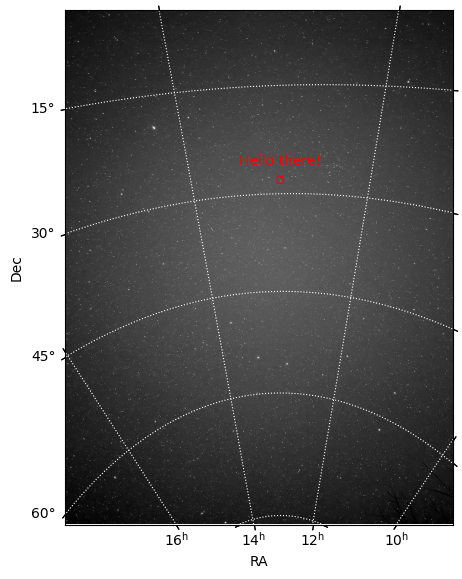

In [131]:
from matplotlib.patches import Polygon
from scipy.spatial import ConvexHull

hdu = fits.open("new-image.fits")[0]
wcs = WCS(hdu.header, naxis=2)
image_data = hdu.data.mean(axis=0)
x_pixel, y_pixel = wcs.all_world2pix(194.95, 27.98 , 1)
print(coma_coords)

# Find the window that we observed by taking RA_coma +/- 0.5 degrees and DEC_coma +/- 0.5 degrees
corner1 = wcs.all_world2pix(194.95 - 0.5, 27.98 + 0.5, 1)

corner3 = wcs.all_world2pix(194.95 - 0.5, 27.98 - 0.5, 1)

corner4 = wcs.all_world2pix(194.95 + 0.5, 27.98 - 0.5, 1)
corner2 = wcs.all_world2pix(194.95 + 0.5, 27.98 + 0.5, 1)
window_pixel = np.array([corner1, corner2, corner3, corner4])

hull = ConvexHull(window_pixel)
ordered_points = window_pixel[hull.vertices]

polygon = Polygon(ordered_points, closed=True, fill=False, edgecolor='red', linewidth=1, label='Window', alpha=0.9)

print(ordered_points)



# Create the figure first
fig = plt.figure(figsize=(5, 10))
ax = fig.add_subplot(111, projection=wcs)

# Scatter plot of RA/Dec (coma coordinates)
# RA = 194.95, Dec = 27.98
#ax.scatter(window_pixel[:,0], window_pixel[:,1], c='red', marker='.', s=40, linewidths=0.8, alpha=1, label='Coma', zorder=10)
ax.add_patch(polygon)
ax.text(x_pixel, y_pixel +150, "Hello there!", color='red', fontsize=10, ha='center', va='center')

# Plot the image
ax.imshow(image_data, origin='lower', cmap='gray')

# WCS grid and labels
ax.coords.grid(True, color='white', ls='dotted')
ax.set_xlabel('RA')
ax.set_ylabel('Dec')

# Show the plot
plt.show()

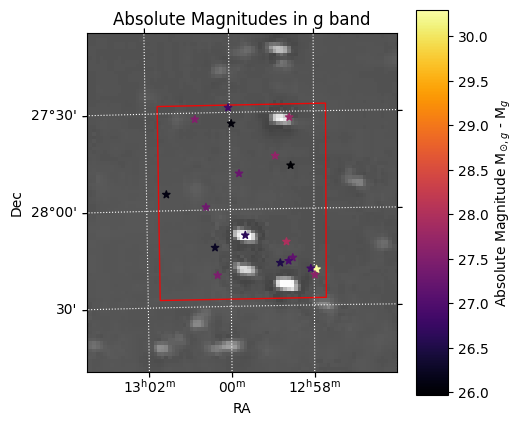

In [330]:
from astropy.visualization.wcsaxes import SphericalCircle

# Calculating Luminosities from Magnitudes in the w1 band
Mag_sun_g = 5.15
luminosity_proportional1 = (Mag_sun_g - lofar_matched['g_rest']) 

# create the figure again and the same polygon again (because python is python)
fig = plt.figure(figsize=(5, 10))
ax = fig.add_subplot(111, projection=wcs)
ax.imshow(image_data, origin='lower', cmap='gray')
polygon2 = Polygon(ordered_points, closed=True, fill=False, edgecolor='red', linewidth=1, label='Window', alpha=0.9)

# convert LOFAR scatter coordinates to pixel coordinates
x_pixel_lofar, y_pixel_lofar = wcs.all_world2pix(lofar_matched['optRA'], lofar_matched['optDec'], 1)


# WCS grid and labels
ax.coords.grid(True, color='white', ls='dotted')
scatter = ax.scatter(x_pixel_lofar, y_pixel_lofar, marker='*', c=luminosity_proportional1, cmap='inferno', s=30, linewidths=1, zorder=10)
colorbar = fig.colorbar(scatter, ax=ax, orientation='vertical', shrink=0.5, aspect=12, pad=0.05)
colorbar.set_label(r'Absolute Magnitude M$_{\odot, g}$ - M$_{g}$', fontsize=10)

ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.set_xlim(1681 -20 , 1727+20)
ax.set_ylim(2704 -20 , 2758+20)
ax.set_title('Absolute Magnitudes in g band')
ax.add_patch(polygon2)





Let's estimate the absolute magnitude with the redshift

MAKE THE SIZE THE ABSOLUTE MAG BRUV

<>:31: SyntaxWarning: invalid escape sequence '\o'
<>:31: SyntaxWarning: invalid escape sequence '\o'
C:\Users\Sven\AppData\Local\Temp\ipykernel_1608\647194280.py:31: SyntaxWarning: invalid escape sequence '\o'
  colorbar.set_label('Luminosity L$_w$ ($10^{-8}$ L$_{\odot}$)')
C:\Users\Sven\AppData\Local\Temp\ipykernel_1608\647194280.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  lofar_matched['w1_rest'].fillna(0, inplace=True)
C:\Users\Sven\AppData\Local\Temp\ipykernel_1608\647194280.py:12: SettingWithCopyWarning: 
A valu

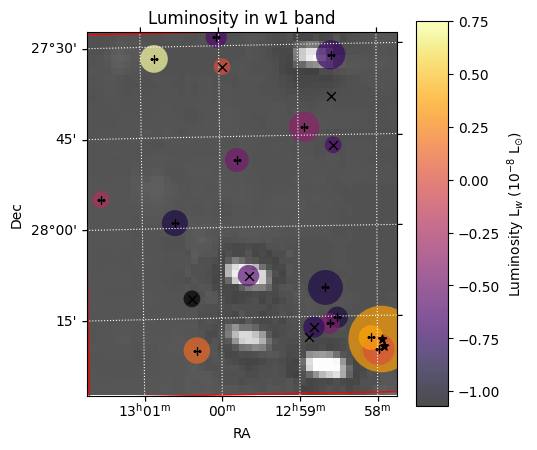

In [320]:
# create the figure again and the same polygon again (because python is python)
fig = plt.figure(figsize=(5, 10))
ax = fig.add_subplot(111, projection=wcs)
ax.imshow(image_data, origin='lower', cmap='gray', zorder=0)
polygon3 = Polygon(ordered_points, closed=True, fill=False, edgecolor='red', linewidth=1, label='Window', alpha=0.9)

# convert LOFAR scatter coordinates to pixel coordinates
x_pixel_lofar, y_pixel_lofar = wcs.all_world2pix(lofar_matched['optRA'], lofar_matched['optDec'], 1)

# Calculating Luminosities from Magnitudes in the w1 band
Mag_sun_w1 = 3.24
lofar_matched['w1_rest'].fillna(0, inplace=True)
luminosity_proportional = 10**(0.4*(Mag_sun_w1 - lofar_matched['w1_rest'])) /10**8

# WCS grid and labels
ax.coords.grid(True, color='white', ls='dotted')
for i in range(22):
    if lofar_matched['type'].iloc[i] in [b'REX',b'EXP']:
        marker = 'x'
        eta = 0.7
    elif lofar_matched['type'].iloc[i] in [b'PSF']:
        marker = '*'
        eta = 1
    else:
        marker = '+'
        eta = 0.4
    ax.scatter(x_pixel_lofar[i], y_pixel_lofar[i], marker=marker, c='black', s=40, linewidths=1, alpha=1, zorder=10)

scatter = ax.scatter(x_pixel_lofar, y_pixel_lofar, marker='o', c=Spectral_index, cmap='inferno', s=luminosity_proportional, linewidths=1, edgecolors='none', zorder=1, alpha = 0.7)
colorbar = fig.colorbar(scatter, ax=ax, orientation='vertical', shrink=0.5, aspect=12, pad=0.05)
colorbar.set_label('Luminosity L$_w$ ($10^{8}$ L$_{\odot}$)')

ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.set_xlim(1681  , 1727)
ax.set_ylim(2704  , 2758)
ax.set_title('Luminosity in w1 band')
ax.add_patch(polygon3)



